# Using BERT to Identify the Narrators (Binary Classification)

While binary classification [reliably identifies one of the narrators](2_BERT_binary_classification_bill.ipynb) (Bill Hardy), multiclass classification [performs very poorly](3_BERT_multiclass_classification_WIP.ipynb).

There is some paradox. To investigate it, we can compare the outputs of binary classification applied to each narrator.

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with a column per narrator, `1` if a page belongs to a given narrator, `0` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def get_narrator(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key
    return None


df = df.astype({"text": "string"})

# create one boolean column per narrator
dummies = pd.get_dummies(df["page"].apply(lambda x: get_narrator(x)).str.get_dummies())

df = pd.concat([df, dummies], axis=1)
df = df.astype({col: "int" for col in dummies.columns})
df

,page,text,Bill Hardy,Clement DeAth,Henry (dog),Jasmine Gay,John Walker,May Doncaster,Oscar Mills,Sir Paul Trinder
0,1,I sit down alone at the appointed table and ta...,1,0,0,0,0,0,0,0
1,2,I plunged for the last time. The few remaining...,0,0,0,0,0,0,1,0
2,3,"At my meeting with Clement yesterday, he had b...",0,0,0,0,1,0,0,0
3,4,And I really think I would have preferred the ...,1,0,0,0,0,0,0,0
4,5,I hated my eye for being caught by what didn’t...,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,96,Now I think I will try a cup of what they inso...,1,0,0,0,0,0,0,0
96,97,To have slept and to wake right up surrounded ...,0,0,0,0,1,0,0,0
97,98,He stood and looked down at me; but I was not ...,0,0,0,0,0,0,0,1
98,99,"And she wore a mauve love-knot on her breast, ...",0,0,1,0,0,0,0,0


---

The approach initially used for Bill is transposed to all narrators.

## Training

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT base uncased model
# https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

In [5]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion:

* **4 pages beloging to a given narrator**, and
* **25 pages from other narrators**

The size of the test dataset is 20% of the sampled subset of the book.

In [6]:
from sklearn.model_selection import train_test_split


def get_datasets(df, narrator):
    # sample 40% of the narrator pages/sentences and 30% of all pages/sentences
    df_is_narrator = df[df[narrator] == 1].sample(frac=0.4)
    df_not_narrator = df[df[narrator] == 0].sample(frac=0.3)

    df_sampled = pd.concat([df_is_narrator, df_not_narrator], axis=0)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled[narrator].values,
        test_size=None,
        random_state=42,
    )

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }

In [8]:
from transformers import AdamW
import copy


def train(df, narrator):
    train_texts, _, train_labels, _ = get_datasets(df, narrator)

    train_dataloader = DataLoader(
        TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
        batch_size=batch_size,
        shuffle=False,
    )

    print(f"Train dataset size: {train_texts.shape[0]}")

    model = copy.deepcopy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            if input_ids.numel() < batch_size or labels.numel() < batch_size:
                continue

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)

            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model

## Prediction

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int).flatten()

    return predicted_labels

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels, narrator):
    cm = confusion_matrix(df[narrator].values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Someone else", narrator]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()

In [11]:
import matplotlib.patches as mpatches


def represent_pages(df, narrator):
    cols, rows = 10, 10

    expected_pages = [
        page - 1 for page in df[df[narrator] == 1]["page"].values.tolist()
    ]
    predicted_pages = [
        index for index, value in enumerate(predicted_labels) if value == 1
    ]

    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

    for i, ax in enumerate(axs.ravel()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_patch(
            plt.Rectangle(
                (0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF"
            )
        )
        row, col = divmod(i, cols)
        ax.text(
            0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8
        )

    common_indices = set.intersection(set(expected_pages), set(predicted_pages))

    for index in expected_pages + predicted_pages:
        row, col = divmod(index, cols)

        if index in common_indices:
            # pages adequately predicted
            axs[row, col].patches[0].set_facecolor("#FFE871")
            axs[row, col].text(
                0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
            )
        elif index in expected_pages:
            # pages erroneously not predicted
            axs[row, col].patches[0].set_facecolor("#A6B7DE")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )
        else:
            # pages erroneously predicted
            axs[row, col].patches[0].set_facecolor("#DEA6BA")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )

    plt.legend(
        handles=[
            mpatches.Patch(color="#FFE871", label="Correct Prediction"),
            mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
            mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        ncol=3,
    )

    fig.set_size_inches(12, 10)
    plt.subplots_adjust(
        top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1
    )

    plt.show()

----
# Narrators

## Oscar Mills
<img src="https://glthr.com/cj/characters/oscar-min.jpg" alt="drawing" width="400"/>

In [12]:
narrator = "Oscar Mills"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5795
2/20 — loss: 0.4507
3/20 — loss: 0.4314
4/20 — loss: 0.3821
5/20 — loss: 0.3399
6/20 — loss: 0.3028
7/20 — loss: 0.2646
8/20 — loss: 0.2260
9/20 — loss: 0.1947
10/20 — loss: 0.1943
11/20 — loss: 0.1629
12/20 — loss: 0.1334
13/20 — loss: 0.1092
14/20 — loss: 0.0681
15/20 — loss: 0.0568
16/20 — loss: 0.0393
17/20 — loss: 0.0283
18/20 — loss: 0.0207
19/20 — loss: 0.0167
20/20 — loss: 0.0145


<Figure size 800x600 with 0 Axes>

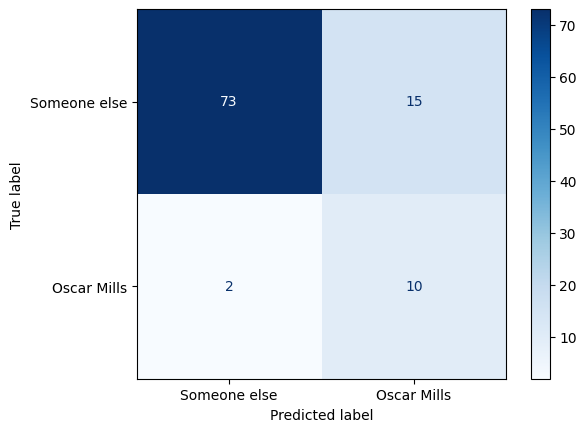

In [13]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

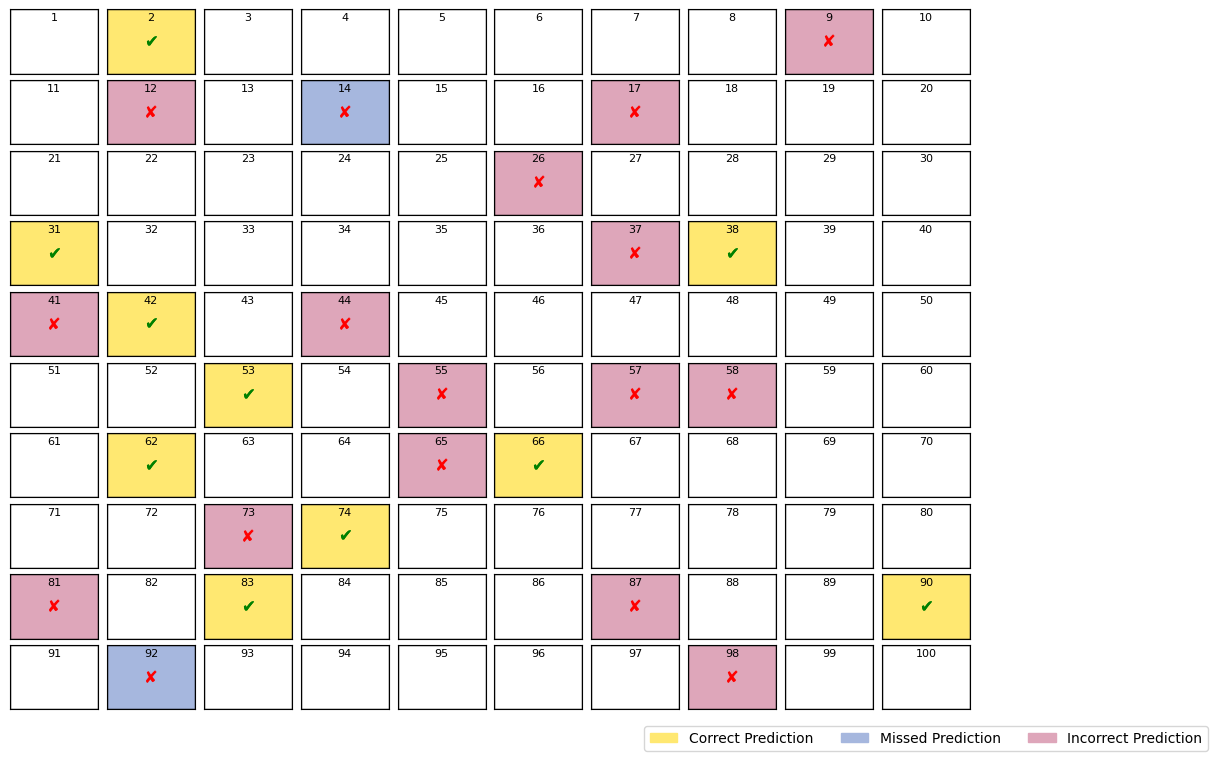

In [14]:
represent_pages(df, narrator)

## May Doncaster
<img src="https://glthr.com/cj/characters/may-min.jpg" alt="drawing" width="400"/>

In [15]:
narrator = "May Doncaster"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5663
2/20 — loss: 0.5085
3/20 — loss: 0.4616
4/20 — loss: 0.4233
5/20 — loss: 0.3671
6/20 — loss: 0.3182
7/20 — loss: 0.2601
8/20 — loss: 0.1975
9/20 — loss: 0.1565
10/20 — loss: 0.1352
11/20 — loss: 0.0940
12/20 — loss: 0.0783
13/20 — loss: 0.0576
14/20 — loss: 0.0428
15/20 — loss: 0.0297
16/20 — loss: 0.0275
17/20 — loss: 0.0198
18/20 — loss: 0.0163
19/20 — loss: 0.0143
20/20 — loss: 0.0118


<Figure size 800x600 with 0 Axes>

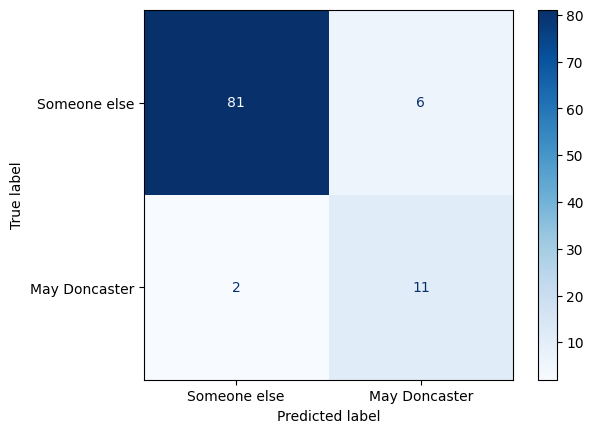

In [16]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

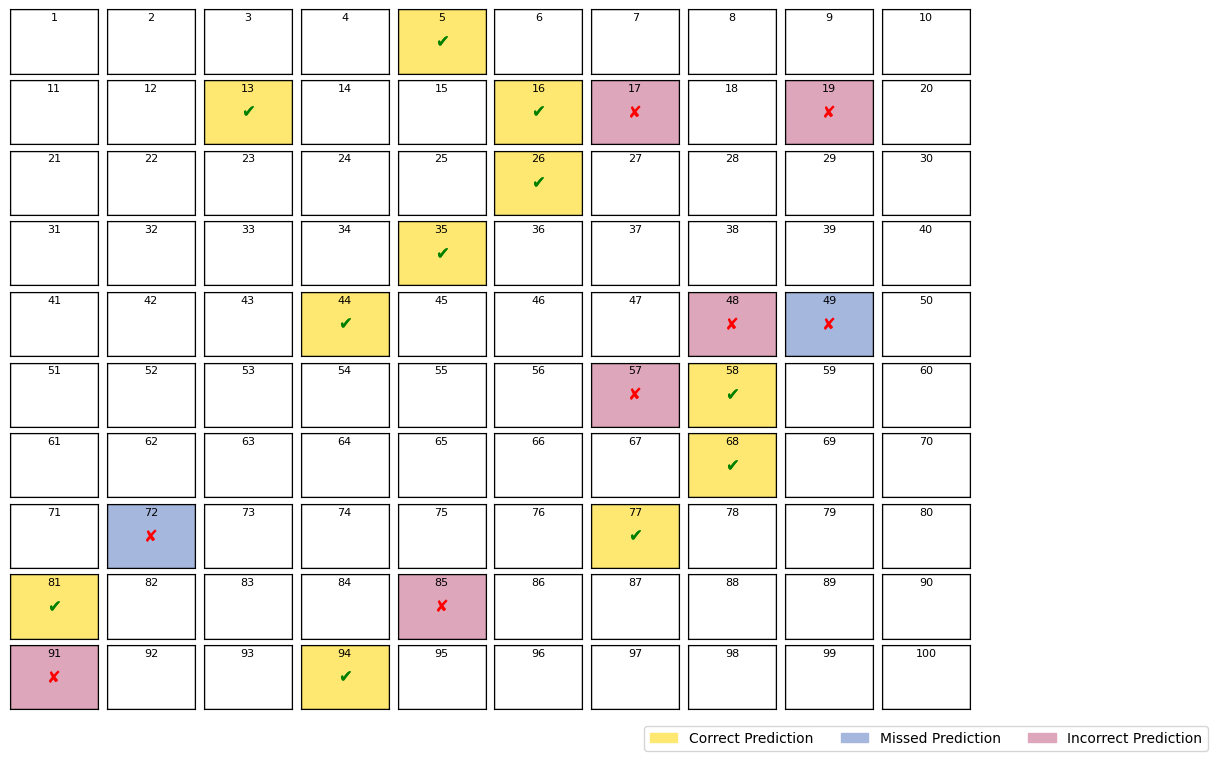

In [17]:
represent_pages(df, narrator)

## Sir Paul Trinder
<img src="https://glthr.com/cj/characters/paul-min.jpg" alt="drawing" width="400"/>

In [18]:
narrator = "Sir Paul Trinder"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5660
2/20 — loss: 0.4867
3/20 — loss: 0.4477
4/20 — loss: 0.3818
5/20 — loss: 0.3347
6/20 — loss: 0.2770
7/20 — loss: 0.2239
8/20 — loss: 0.1901
9/20 — loss: 0.1420
10/20 — loss: 0.1110
11/20 — loss: 0.0827
12/20 — loss: 0.0648
13/20 — loss: 0.0474
14/20 — loss: 0.0413
15/20 — loss: 0.0310
16/20 — loss: 0.0254
17/20 — loss: 0.0215
18/20 — loss: 0.0167
19/20 — loss: 0.0153
20/20 — loss: 0.0141


<Figure size 800x600 with 0 Axes>

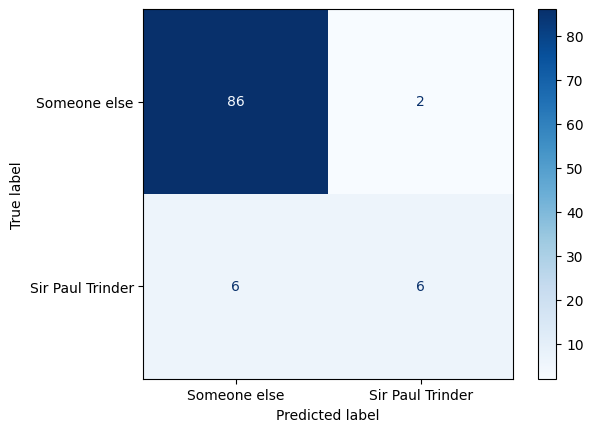

In [19]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

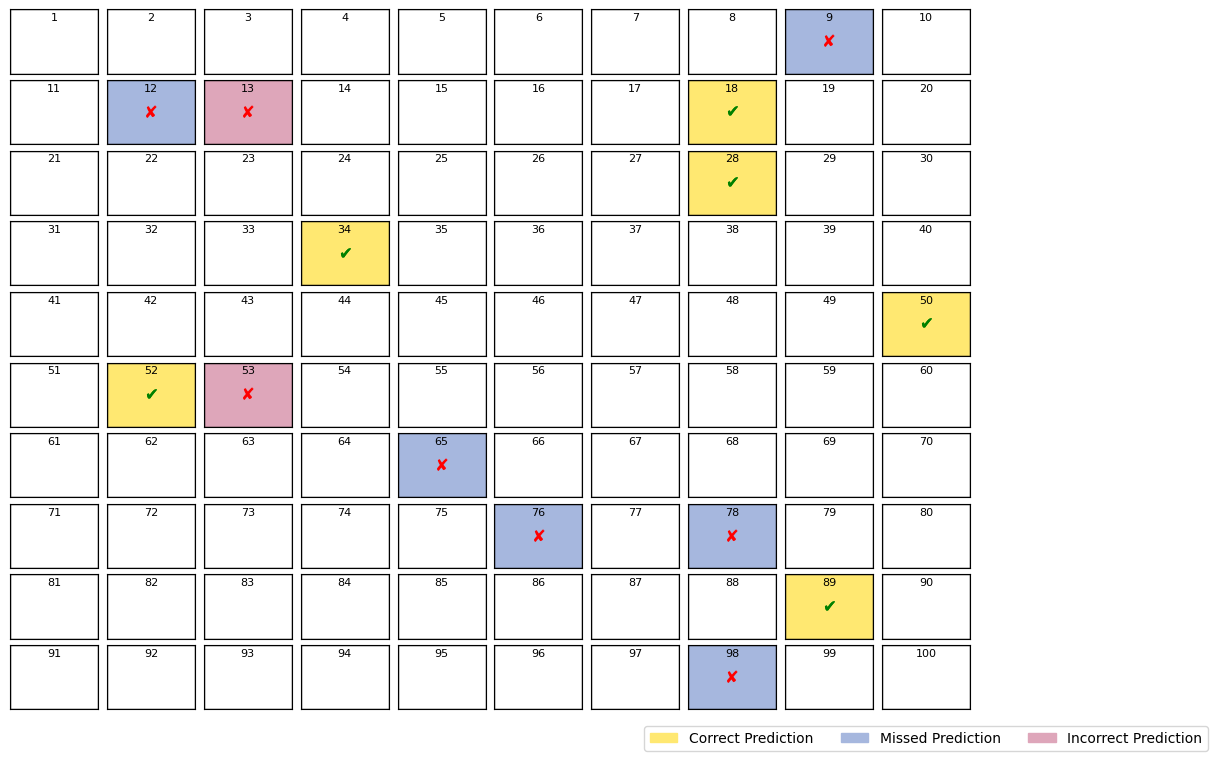

In [20]:
represent_pages(df, narrator)

## Clement DeAth
<img src="https://glthr.com/cj/characters/clement-min.jpg" alt="drawing" width="400"/>

In [21]:
narrator = "Clement DeAth"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5529
2/20 — loss: 0.5114
3/20 — loss: 0.4680
4/20 — loss: 0.4802
5/20 — loss: 0.4549
6/20 — loss: 0.4233
7/20 — loss: 0.3859
8/20 — loss: 0.3125
9/20 — loss: 0.2757
10/20 — loss: 0.2294
11/20 — loss: 0.1855
12/20 — loss: 0.1553
13/20 — loss: 0.1121
14/20 — loss: 0.0787
15/20 — loss: 0.0614
16/20 — loss: 0.0463
17/20 — loss: 0.0341
18/20 — loss: 0.0254
19/20 — loss: 0.0213
20/20 — loss: 0.0179


<Figure size 800x600 with 0 Axes>

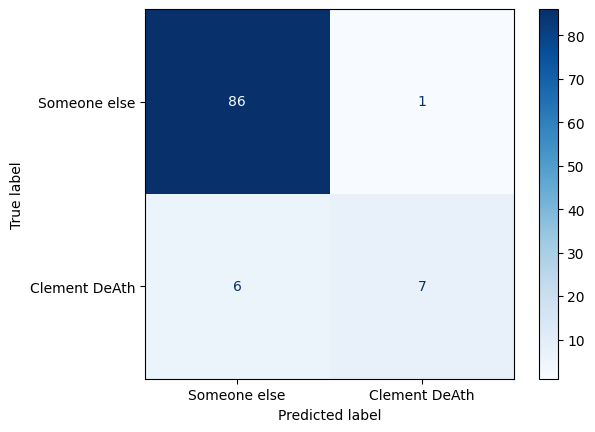

In [22]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

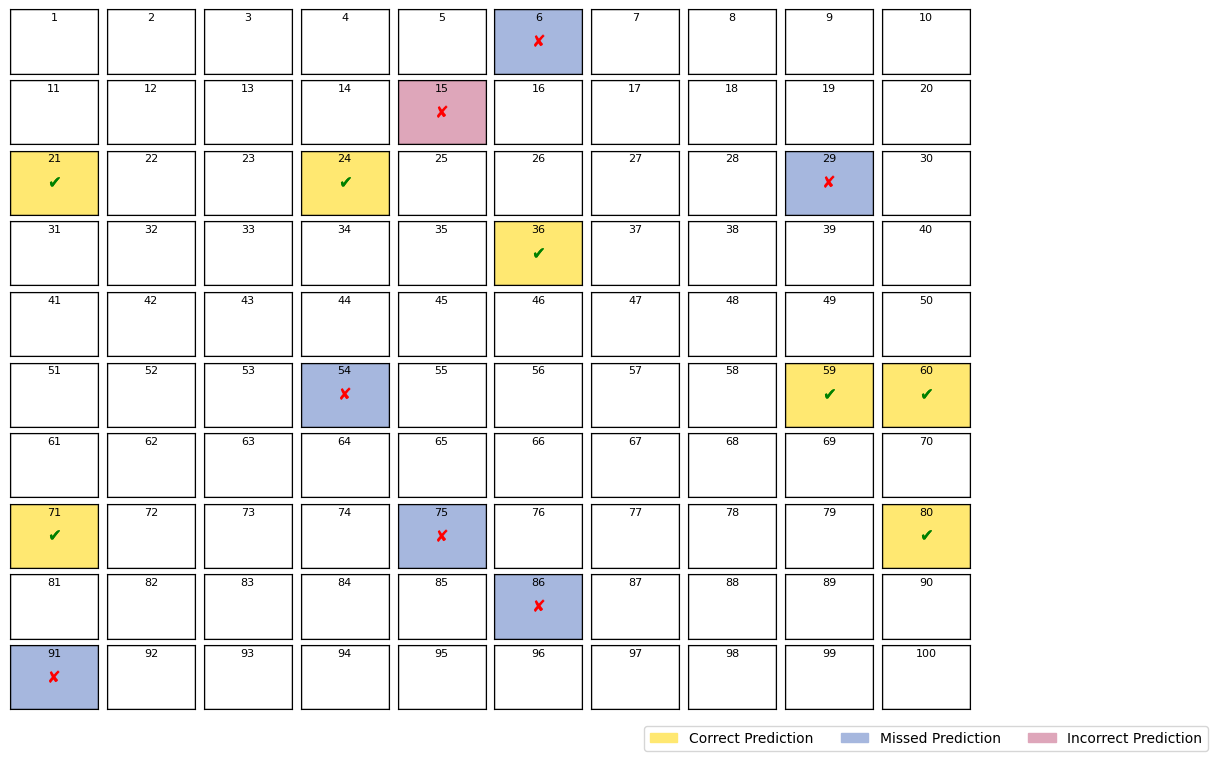

In [23]:
represent_pages(df, narrator)

## Bill Hardy
<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [24]:
narrator = "Bill Hardy"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5628
2/20 — loss: 0.4839
3/20 — loss: 0.4236
4/20 — loss: 0.3548
5/20 — loss: 0.3062
6/20 — loss: 0.2525
7/20 — loss: 0.1950
8/20 — loss: 0.1489
9/20 — loss: 0.1134
10/20 — loss: 0.0823
11/20 — loss: 0.0716
12/20 — loss: 0.0531
13/20 — loss: 0.0427
14/20 — loss: 0.0342
15/20 — loss: 0.0297
16/20 — loss: 0.0240
17/20 — loss: 0.0201
18/20 — loss: 0.0169
19/20 — loss: 0.0149
20/20 — loss: 0.0123


<Figure size 800x600 with 0 Axes>

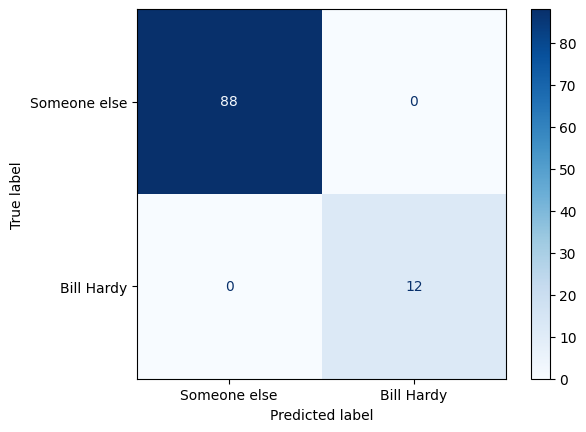

In [25]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

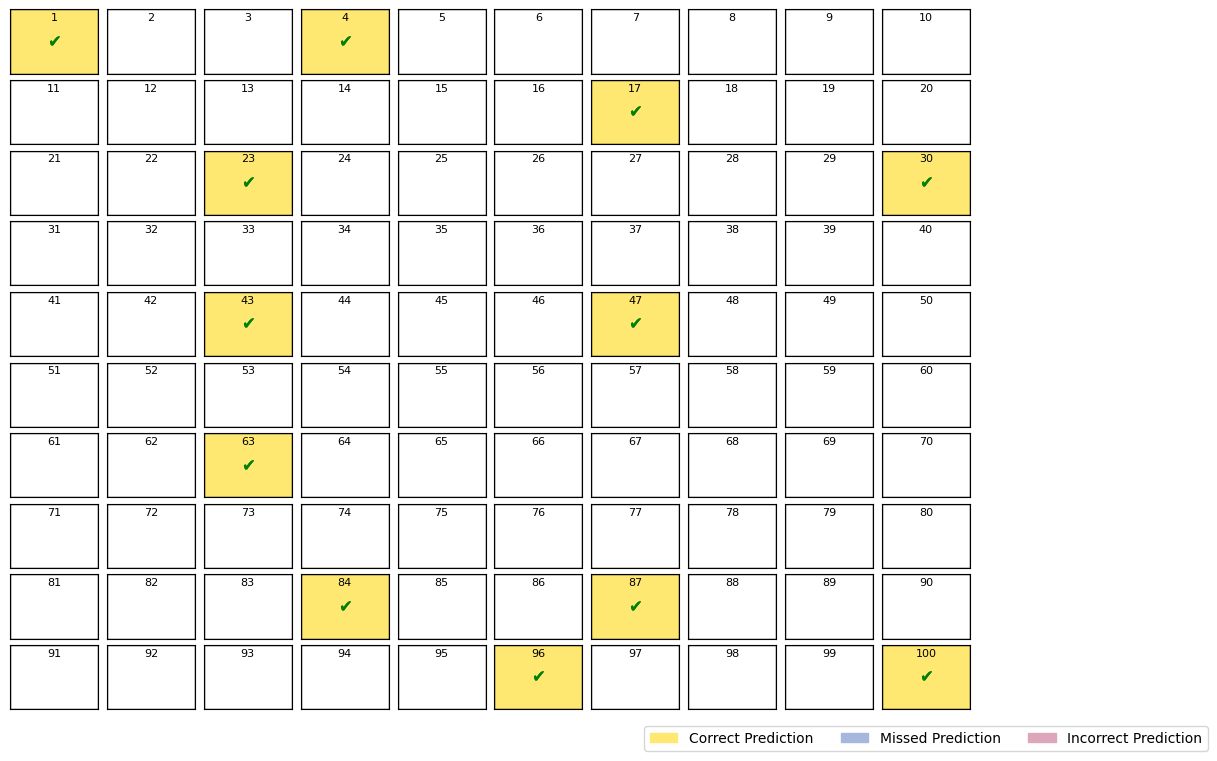

In [26]:
represent_pages(df, narrator)

## Jasmine Gay
<img src="https://glthr.com/cj/characters/jasmine-min.jpg" alt="drawing" width="400"/>

In [27]:
narrator = "Jasmine Gay"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.6149
2/20 — loss: 0.5062
3/20 — loss: 0.4601
4/20 — loss: 0.4303
5/20 — loss: 0.3773
6/20 — loss: 0.3258
7/20 — loss: 0.2874
8/20 — loss: 0.2439
9/20 — loss: 0.2125
10/20 — loss: 0.1850
11/20 — loss: 0.1433
12/20 — loss: 0.1107
13/20 — loss: 0.0879
14/20 — loss: 0.0677
15/20 — loss: 0.0570
16/20 — loss: 0.0420
17/20 — loss: 0.0302
18/20 — loss: 0.0220
19/20 — loss: 0.0201
20/20 — loss: 0.0161


<Figure size 800x600 with 0 Axes>

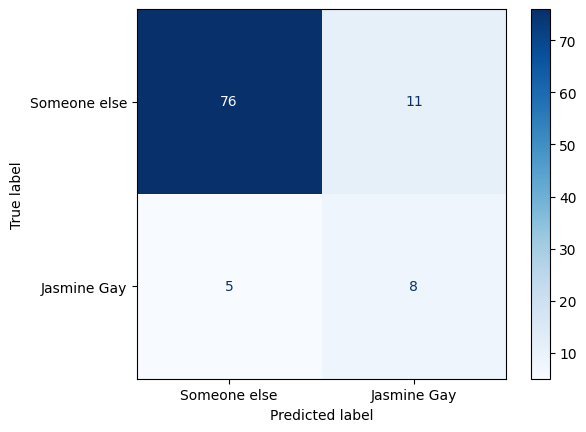

In [28]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

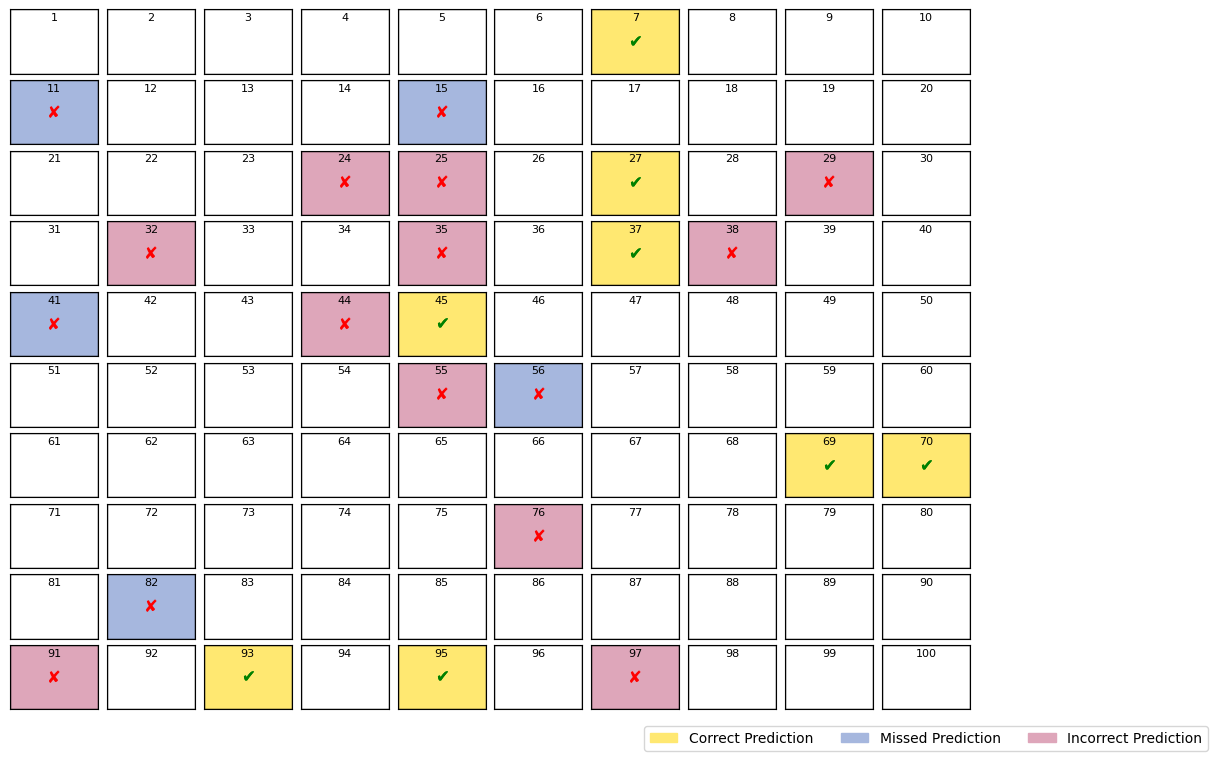

In [29]:
represent_pages(df, narrator)

## John Walker
<img src="https://glthr.com/cj/characters/john-min.jpg" alt="drawing" width="400"/>

In [30]:
narrator = "John Walker"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5528
2/20 — loss: 0.4729
3/20 — loss: 0.4641
4/20 — loss: 0.4329
5/20 — loss: 0.3909
6/20 — loss: 0.3653
7/20 — loss: 0.3177
8/20 — loss: 0.2851
9/20 — loss: 0.2374
10/20 — loss: 0.2276
11/20 — loss: 0.2101
12/20 — loss: 0.1849
13/20 — loss: 0.1693
14/20 — loss: 0.1346
15/20 — loss: 0.1180
16/20 — loss: 0.1054
17/20 — loss: 0.0820
18/20 — loss: 0.0713
19/20 — loss: 0.0519
20/20 — loss: 0.0496


<Figure size 800x600 with 0 Axes>

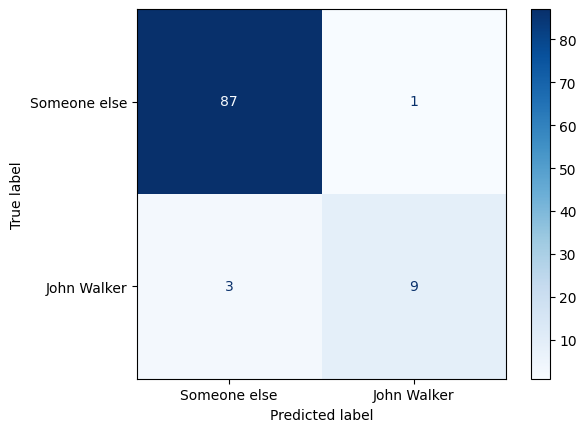

In [31]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

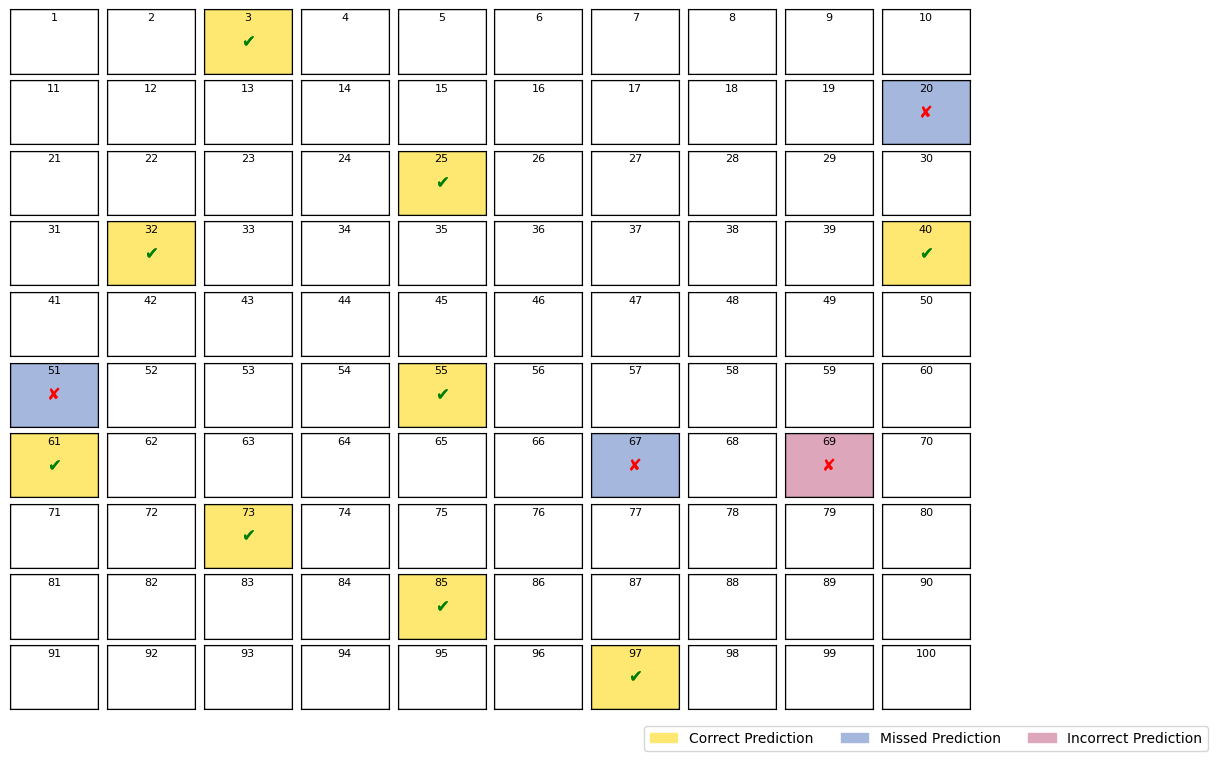

In [32]:
represent_pages(df, narrator)

## Henry (dog)
<img src="https://glthr.com/cj/characters/henry-min.jpg" alt="drawing" width="400"/>

In [33]:
narrator = "Henry (dog)"
model = train(df, narrator)

Train dataset size: 23
1/20 — loss: 0.5739
2/20 — loss: 0.4676
3/20 — loss: 0.4086
4/20 — loss: 0.3477
5/20 — loss: 0.3180
6/20 — loss: 0.2534
7/20 — loss: 0.1971
8/20 — loss: 0.1485
9/20 — loss: 0.1219
10/20 — loss: 0.0850
11/20 — loss: 0.0700
12/20 — loss: 0.0546
13/20 — loss: 0.0432
14/20 — loss: 0.0376
15/20 — loss: 0.0306
16/20 — loss: 0.0265
17/20 — loss: 0.0212
18/20 — loss: 0.0184
19/20 — loss: 0.0154
20/20 — loss: 0.0140


<Figure size 800x600 with 0 Axes>

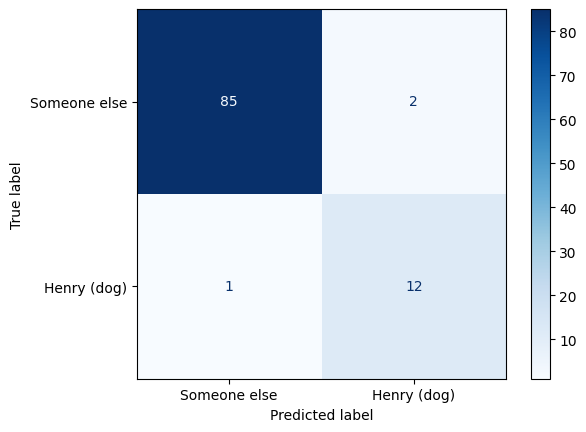

In [34]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

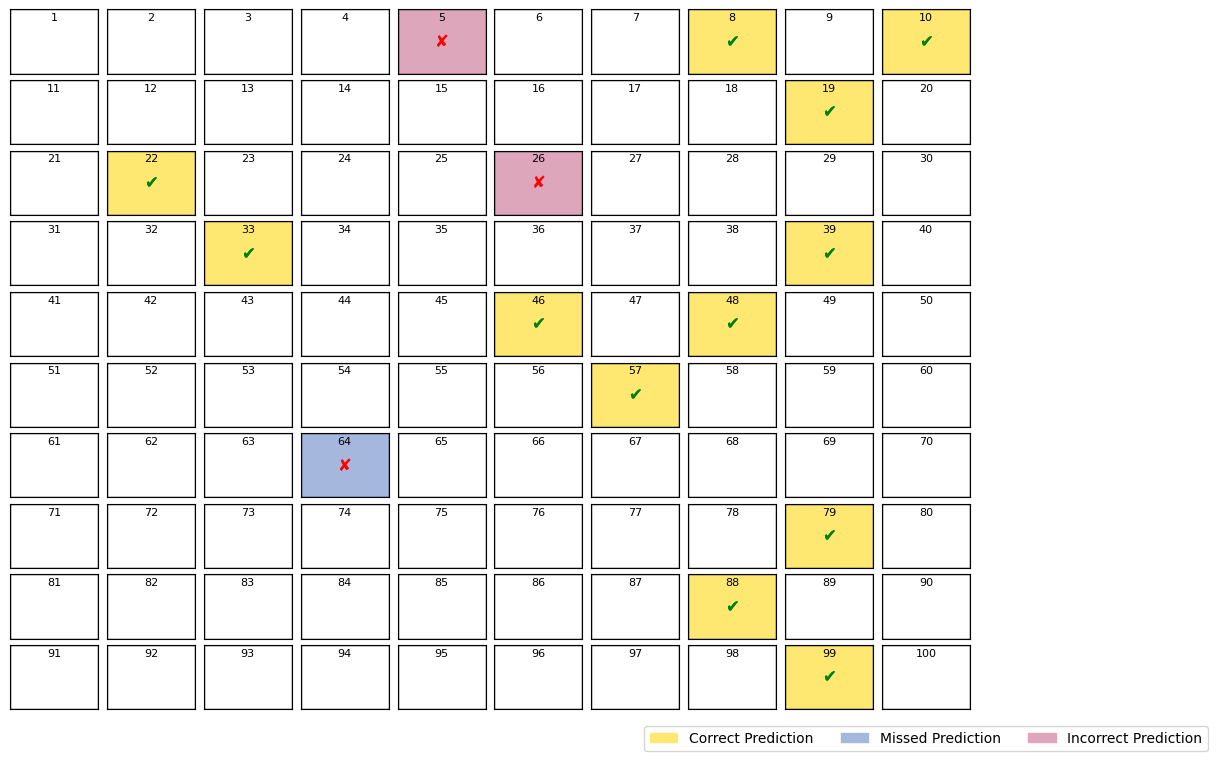

In [35]:
represent_pages(df, narrator)

# Results

Applying binary classification to all narrators reveals a compelling finding: **Bill Hardy is the only narrator who can be reliably identified by the model**, confirming the observation of the multiclass classification results. 

Additionally, **the model achieves good results in identifying Henry’s pages, corroborating the K-means findings**.

# Analysis

Pages belonging to Bill Hardy have a characteristic that distinguishes them from other narrators—from the model perspective. This characteristic can be assumed intratextual, based on the pages’ lexical and/or grammatical structure. But which one?

An observation [made while solving the book](https://glthr.com/cj/#bill) can help form a hypothesis:

<img src="bill_description.png" alt="Bill narrates in the present tense" style="border: 2px solid  gray;" width="400">

It appears that Bill Hardy is the only narrator speaking in the *present* tense.

Note that the characteristics of Henry’s pages are less apparent.